# Deterministic Models

# Team Members:
- Francesco Slataper
- Jakob Poerschmann
- Ignacio Vidal-Quadras Costa
- Eduard Gimenez Funes

# Exercise 1

__Concavity of the function:__

The objective function $l(K|S)=\log(det(K))-tr(SK)$ is concave since $tr(SK)$ is linear in $K$, whilst $\log(det(K))$ is concave over any line $(1-t)K+tB$ given that $K$ and $B$ are PD matrices. 

This is easily proven considering that 

 $$log(det((1-t)K + tB) =log(det(K^{\frac{1}{2}}((1-t)I+tK^{-\frac{1}{2}}BK^{-\frac{1}{2}})K^{\frac{1}{2}})=log(det((1-t)K))+\sum{log((1-t)+t\lambda_i})$$

Since the logarithm of the determinant is a constant, and $\log(1+t\lambda_i)$ is concave in t, the whole function is concave.

The set M is convex since, for $K \in M$, any matrix of the type $(1-t)B+tK, t \in [0,1]$ will also be in M, since both t and 1-t are obviously positive so no element change sign.



__Problem formalation:__



- __Lagrangian__:

\begin{align}
  l^* & = -l(K|S) + \lambda^Tg(K) \\
  \\
  g_{ij}(x)  & : x_{ij} \leq 0 \text{ for $i\neq j$} \\
  h_{jj}(x)  & : x_{ij} - x_{ji} = 0 \leq 0
\end{align}
  

- __Duality problem:__ One approach to the problem can be to take the supermum for all non-negative lambdas of the infimum for all K's of the Lagrangian which is now  a function of lambda.
$$ \inf_{\lambda^*\geq0}\sup_{K\in R^{d \times d}} (l^*(K|S) - \lambda^T * g(K))$$
For any $\lambda \geq 0$, we know that the dual function sets a lower bound on the optimal value of $l$ and thus (a fortiori) on the maximum of the objective function


- __KKT conditions:__
Let $\lambda^* \in R^m$ be the optimal dual vector and $K^* \in R^{d \times d}$ the optimal primal vector. The following conditions are necessary and sufficient for $K^*$ to be the global optimum.

- __Primal Feasibility:__  $g(K^*) \leq 0$.

- __Dual Feasibility:__ $\lambda^* \geq 0$.

- __Complementary Slackness:__ $\lambda^*_i g_i=0 \text{ for i=1, ..., m}$.

- __Lagrangian Condition:__ The pair $(K^*, \lambda^*)$ satisfies

$$\nabla_K L(K^* , \lambda^*) =\nabla f(K^*)+\sum_{i=1}^{m} \lambda^*_i \nabla g_i (K^*)  = 0 $$






__Observation 1:__ This is the formal problem setup. Computationally, taking advantage of the simmetry of the problem,  we reduce the search spaces from to  $R^{d \times d}$  $R^{\frac{(d-1)d}{2}}$.

__Observation 2:__ It is not necessary to control for $K$ been $PSD$ explicitly as a set of conditions.

__Proof:__
First we will prove that $A = \{K \in PSD\}$ is an open set and $\partial A$ is equal to the $\{K s.t. \det(K)=0\}$

For each diagonal matrix $D$ s.t. all the eigenvalues are positive we can think of the $O^t \times D \times O$. 
Where $O = \{M \in R^{d \times d} s.t. M^t M = I\}$.
Now when we consider this  product for all diagonal matrices, this is an open set. It's boundary is the elements whose eigenvalues contain zeros or infinite.

The value of our function in the boundary is $-\infty$ therefore, since the optimizer would never follow a descending path, if we star inside A we continue on A.



In [1]:
# install.packages("psych")
# install.packages('CVXR')
# install.packages("MASS")
# install.packages("ggplot2")


In [2]:
library(psych)
library(MASS)
library(ggplot2)
library(CVXR)
options(warn=-1)


Attaching package: 'ggplot2'

The following objects are masked from 'package:psych':

    %+%, alpha

Warning message:
"package 'CVXR' was built under R version 3.6.3"
Attaching package: 'CVXR'

The following object is masked from 'package:MASS':

    huber

The following object is masked from 'package:psych':

    logistic

The following object is masked from 'package:stats':

    power



# Exercise 2

To have a benchmark for the optimization, we used the standard R library for convex optimization, CVXR: https://cvxr.rbind.io/

The optimization was subject to two constraints. Firstly, the PSD constraint, which we defined in the Variable. Secondly negative values off the diaginal of K, which we defined on an object basis.

In [3]:
exercise_2 <- function(S, pre = 1e-1, max_iter = 100){
  n <- dim(S)[1]
  
  K  <- Variable(n, n, PSD = TRUE)     ## Variable constrained to positive semidefinite cone
  
  obj <- Maximize(log_det(K) - matrix_trace(S %*% K))

  ix <- 1
  constr <- list()
  
  for (i in 1:n){
    for (j in 1:n){
      if (i == j){
        constr[ix] <- K[i, j] >= 0
      }else{
        constr[ix] <- K[i, j] <= 0
      }
      ix <- ix + 1
    }
  }
  
  prob <- Problem(obj,constr)
  result <- solve(prob)

  return(list(result$solve_time, result$num_iters, round(result$getValue(K),2)))
}

# Exercise 3

To develop an algorithm capable of beating general-purpose frameworks in this concrete problem, we have leverage on the following ideas:


- __Coordinate-wise vs Gradient Optimization:__ Gradient is faster if it's not taken into account the time to calculate the gradient. In this type of problem, the cost of this step grows quadratically with the size of the matrix $(n)$.


- __Speeding up the calculation of the function:__ The function to maximize $ f(x) = \log(\det(K)) - tr(SK) $ is also computationally  expensive. The determinant of a matrix grows as $n!$. Taking advantage of the former decision  (coordenate-wise optimization), condition  on $x_{ii}, \det(K)$ it's a linear function and condition on $x_{ij}, \det(K)$ is a quadratic function. Thus once we've chosen the coordinate we will optimize on, we precalculate the function $\det(K)$ as a function of $x_{ij}$ or $x_{ii}$.


- __Turning the problem into an unconstrained problem__: The original optimization problem is constrained to $x_{ij} \leq 0$ and $ x_{ij} \geq 0$ insted of optimizing  $f(x_{ij}$ we will optimize $f(-x_{ij}^2$ and instead of optimizing $f(x_{ii})$ we will optimize $f(x_{ii}^2)$


- __Choosing the initial point:__ The original problem is concave. The unconstrained version $f(-x_{ij}^2), f(x_{ii}^2)$ has $\frac{(n-1)n}{2}$ minimums. In particular diagonal matrices $D$ lay in the boundary of two convergence regions. Thus these are the type of point not to start with. We have chosen $Id - \epsilon $


### So let's get started

### Poli_det

This function generates the polynomial expression of $\det(K)$ condition to $x_{ij}$


In [4]:
poli_det <- function(K, i, j){
  if (i==j){
    # Calculate
    K[i, j] <- 0
    V0 <- det(K)
    K[i, j] <- 1
    V1 <- det(K)
    
    # Solve
    c <- V0
    a <- V1 - c
    
    f <- function(x){
      a*x + c
    }
  }else{
    # Calculate
    K[i, j] <- 0
    K[j, i] <- 0
    V0 <- det(K)
    K[i, j] <- 1
    K[j, i] <- 1
    V1 <- det(K)
    K[i, j] <- -1
    K[j, i] <- -1
    V_1 <- det(K)
    
    # Solve
    c <- V0
    a <- (V1 + V_1 - 2*c)/2
    b <- V1 - c - a
    
    f <- function(x){
      a*x^2+b*x++c
    }
  }
  f
}

### Poli_trace
Calculates the polinomyal expression of $tr(SK)$ condition on $x{ij}$

In [5]:
poli_trace <- function(S, K, i, j){
  if(i==j){
    # Calculate
    K[i, j]<- 0
    V0 <- tr(S%*%K)
    K[i, j]<- 1
    V1 <- tr(S%*%K)
    
    # Solve
    b <- V0
    a <- V1 - b
    
    f <- function(x){
      a*x+b
    }
  }else{
    # Calculate
    K[i, j] <- 0
    K[j, i] <- 0
    V0 <- tr(S%*%K)
    K[i, j] <- 1
    K[j, i] <- 1
    V1 <- tr(S%*%K)

    # Solve
    b <- V0
    a <- V1 - b
    
    f <- function(x){
      a*x+b
    }
  }
}

### Poli_fun

Generates the quasi-polynomial function equivalent to our objective function condition on $x_{ij}$

In [6]:
poli_fun <- function(S, K, i, j){
  pd <- poli_det(K, i, j)
  pt <- poli_trace(S, K, i, j)
  if (i==j){
    function(x){
      log(pd(x^2))-pt(x^2)
    }
  }else{
    function(x){
      log(pd(-x^2))-pt(-x^2)
    }
  }
}

### Poli_par

The following pair of functions calculate the partial derivatives of $f(x)$. This functions will be used to choose which is the best coordinate to performe the optimization

In [7]:
poli_par <- function(f, x0){
  eps = 0.0001
  (f(x0+eps)-f(x0-eps))/(2*eps)
}

poli_par_ij <- function(S, K, i, j){
  f <- poli_fun(S, K, i, j)
  if (i==j){
    par <- poli_par(f, (K[i, j])^.5)
  }else{
    par <- poli_par(f, (-(K[i, j]))^.5)
  }
  par
}

### Find ij

This function chooses the best coordinate to perform the optimization

In [8]:
find_ij <- function(S, K){
  n <- dim(K)[1]
  
  the_i <- 0
  the_j <- 0
  the_v <- -Inf
  
  for (i in 1:n){
    for (j in i:n){
      if (i == j){
        new_v <- abs(poli_par(poli_fun(S, K, i, j), (K[i, j])^.5))
      }else{
        new_v <- abs(poli_par(poli_fun(S, K, i, j), (-K[i, j])^.5))
      }
      
      if (new_v > the_v){
        the_v <- new_v
        the_i <- i
        the_j <- j
      }
    }
  }
  c(the_i, the_j)
}


### Setting all together

Finally we are able to define a procedure that beats a general-purpose optimizer even in low dimensions

In [9]:
# Optimization on coordinate x_{ij}
optimize_f_ij <- function(S, K, i, j){
  f <- poli_fun(S, K, i, j)
  
  if (i == j){
    x0 <- (K[i, j])^.5
  }else{
    x0 <- (-K[i, j])^.5
  }
  
  
  result <- optim(x0, f, control=list(fnscale=-1, reltol=1e-8))
  
  if(i == j){
    K[i,j] <- (result$par)^2
  }else{
    K[i, j] <- -(result$par)^2
    K[j, i] <- -(result$par)^2
  }
  K
}

# API 
exercise_3 <- function(S, pre = 1e-1, max_iter = 100){

  start_time = Sys.time()

  n <- dim(S)[1]
  
  eps <- 0.1
  
  # We set the right epsilon so det(K) > 0 
  while (TRUE){
    K <- diag(n)
    K <- K - eps*matrix(1, nrow = n, ncol = n) 
    
    if (det(K)>0){
      break
      }else{
        eps<-eps/2
      } 
  }

  
  last_value <- Inf
  
  # We make sure that at least each component is maximized once
  for (i in 1:n){
    for (j in i:n){
      aux <- optimize_f_ij(S, K, i, j)
      K <- aux
    }
  }
  
  # Here we could be fancyer
  for (mi in 1:max_iter){
    ij = find_ij(S, K)
    
    i <- ij[1]
    j <- ij[2]
    
    aux <- optimize_f_ij(S, K, i, j)
    K <- aux
  }
        end_time = Sys.time()

  
  return(list(end_time - start_time, max_iter, round(K, 2)))
}

### Solving and Performance Benchmark

We tested both algorithms against a randomly created S. Therefore, we can confirm that the results are identical. The chart finally, compares the performance of both algorithms with respect to the dimensions of the targeted matrix K. While the standard CVXR algorithm grows fast (though not exponential), the solving time of our customized method increases much slower.

In [10]:
#set.seed(1)

n <- 5     ## Dimension of matrix
S <- matrix(rnorm(n*n), ncol=n)
S <- S%*%t(S)

n <- dim(S)[1]
K <- diag(n)

print('exercise_2')
print('this is going to be slow')
Kr_2 <- exercise_2(S, pre=1e-2, max_iter = 100)
print(Kr_2)
print('exercise_3')
print('this is fast')
Kr_3 <- exercise_3(S, pre=1e-2, max_iter = 100)
print(Kr_3)
print('Done!!! ;-)')

[1] "exercise_2"
[1] "this is going to be slow"
[[1]]
[1] 53.0217

[[2]]
[1] 160

[[3]]
      [,1]  [,2] [,3] [,4]  [,5]
[1,]  1.54 -0.51  0.0 0.00  0.00
[2,] -0.51  0.48  0.0 0.00 -0.02
[3,]  0.00  0.00  0.1 0.00  0.00
[4,]  0.00  0.00  0.0 0.12  0.00
[5,]  0.00 -0.02  0.0 0.00  0.13

[1] "exercise_3"
[1] "this is fast"
[[1]]
Time difference of 0.1815231 secs

[[2]]
[1] 100

[[3]]
      [,1]  [,2] [,3] [,4]  [,5]
[1,]  1.54 -0.51  0.0 0.00  0.00
[2,] -0.51  0.48  0.0 0.00 -0.02
[3,]  0.00  0.00  0.1 0.00  0.00
[4,]  0.00  0.00  0.0 0.12  0.00
[5,]  0.00 -0.02  0.0 0.00  0.13

[1] "Done!!! ;-)"


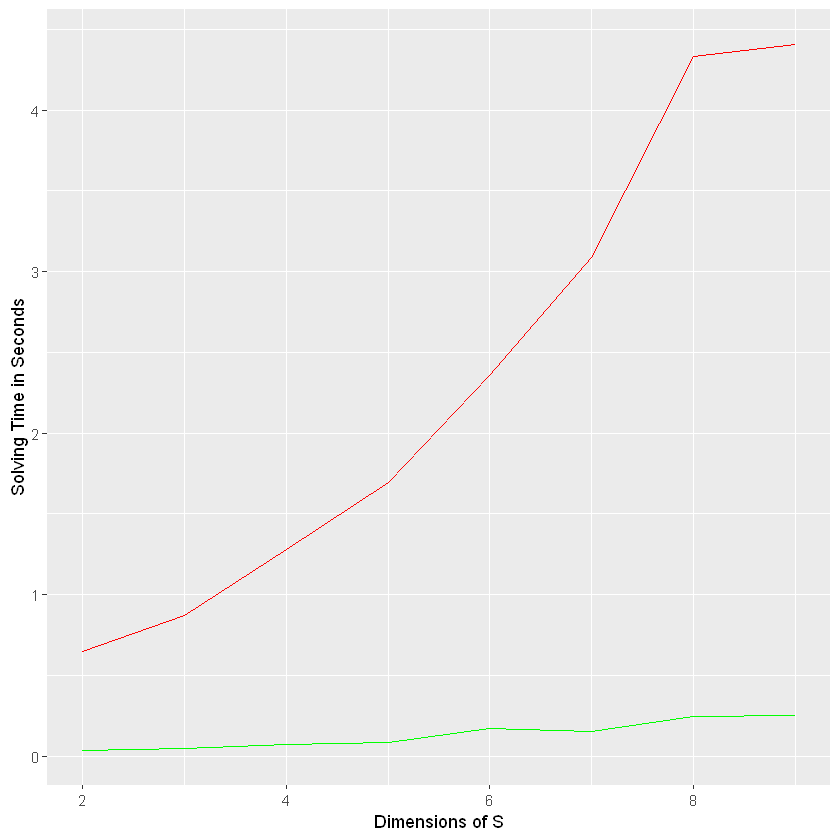

In [11]:
performance_test <- function(lower, upper){

  test_results_df <- data.frame(matrix(ncol = 3, nrow = 0)) ## Dataframe for test results
  colnames(test_results_df) <- c("dimensions", "solving_time_e2", "solving_time_e3")

  for (n in lower:upper) {
    S <- matrix(rnorm(n * n), ncol = n)
    S <- S %*% t(S)

    start_time <- Sys.time()
    res_e2 <- exercise_2(S, pre = 1e-2, max_iter = 1000)
    end_time <- Sys.time()
    time_e2 <- end_time - start_time

    start_time <- Sys.time()
    res_e3 <- exercise_3(S, pre = 1e-2, max_iter = 100)
    end_time <- Sys.time()
    time_e3 <- end_time - start_time


    df <- data.frame(n, time_e2, time_e3) ## result index 1 expected as time
    colnames(df) <- c("dimensions", "solving_time_e2", "solving_time_e3")
    test_results_df <- rbind(test_results_df, df)

  }
  return(test_results_df)
}

test_results_df <- performance_test(2, 9)

ggplot(test_results_df, aes(x=dimensions)) +
  geom_line(aes(y = as.numeric(solving_time_e2)), color = "red") +
  geom_line(aes(y = as.numeric(solving_time_e3)), color = "green") +
  labs(x="Dimensions of S", y="Solving Time in Seconds")

Red (Exercise 2) vs Green (Exercise3)